In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [3]:
from src.utils import get_weeks
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[52:]
week_labels = get_weeks(day_from=20160104, num_weeks=121)[96:]
# week_labels = get_weeks(day_from=20160104, num_weeks=121)[104:]

In [4]:
print(week_labels)

[20171106, 20171113, 20171120, 20171127, 20171204, 20171211, 20171218, 20171225, 20180101, 20180108, 20180115, 20180122, 20180129, 20180205, 20180212, 20180219, 20180226, 20180305, 20180312, 20180319, 20180326, 20180402, 20180409, 20180416, 20180423]


In [5]:
%%time
train = pd.DataFrame()
for name in week_labels[:-1]:
    train = pd.concat([train, pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{name}_SVD_diffscount.feather')])

CPU times: user 8min 26s, sys: 2min 38s, total: 11min 5s
Wall time: 5min 44s


In [6]:
test = pd.read_feather(PROCESSED/f'SVD_17-18_72f/week_{week_labels[-1]}_SVD_diffscount.feather')

## Preprocessing

In [9]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']

In [10]:
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'

In [11]:
%%time
from src.utils import apply_cats
for col in cat_cols:
    test[col] = test[col].astype('category').cat.as_ordered()
apply_cats(train, test)

for col in cat_cols:
    train[col] = train[col].cat.codes
    test[col] = test[col].cat.codes

CPU times: user 48.7 s, sys: 5.53 s, total: 54.3 s
Wall time: 24.8 s


## Model

In [12]:
%%time
y_train = train[target_col]
train.drop(id_cols + [target_col], axis=1, inplace=True)
X_train = train

CPU times: user 5.26 s, sys: 6.49 s, total: 11.8 s
Wall time: 3.9 s


In [13]:
!pip freeze | grep lightgbm

lightgbm==2.1.1


In [14]:
from lightgbm import LGBMClassifier

In [15]:
model = LGBMClassifier(n_estimators=200, silent=False)

In [16]:
%%time
model.fit(X_train, y_train, eval_metric='auc', verbose=True)

CPU times: user 40min 25s, sys: 1min 13s, total: 41min 39s
Wall time: 3min 52s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
%%time
y_pred = model.predict_proba(X_train)[:,1]

In [19]:
roc_auc_score(y_train, y_pred)

0.8133565317323748

In [20]:
from sklearn.metrics import roc_curve

In [23]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred)

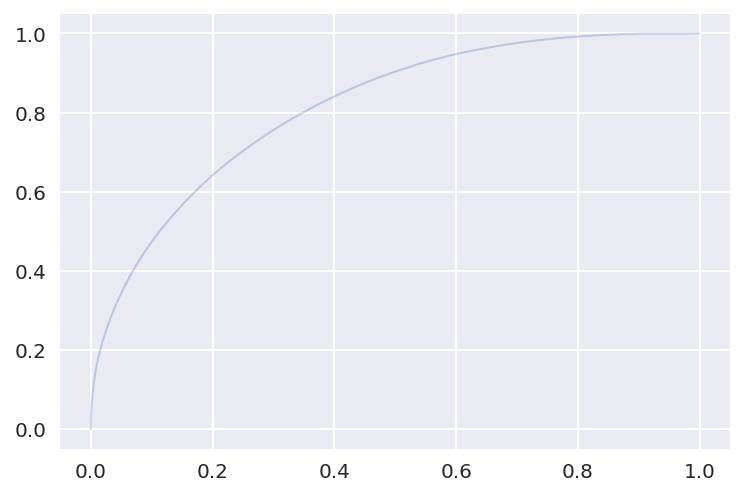

In [24]:
plt.plot(fpr, tpr, lw=1, alpha=0.3)

## Submission

In [25]:
X_test = test.drop(id_cols + [target_col, pred_col], axis=1)

In [26]:
y_test = model.predict_proba(X_test)[:,1]

In [27]:
test[target_col] = y_test

In [28]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [29]:
submission[target_col].describe()

count    484758.000000
mean          0.025367
std           0.037746
min           0.000033
25%           0.008271
50%           0.014850
75%           0.028595
max           0.990625
Name: CustomerInterest, dtype: float64

In [30]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.018927
1,c2cc6cc2a8,0.040081
2,a8e94f6344,0.009788
3,758bae1e35,0.005572
4,02ab378ee8,0.008557


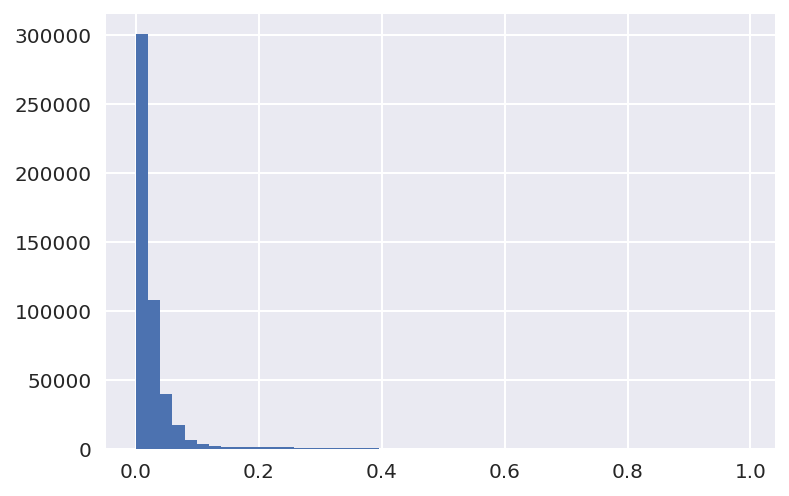

In [31]:
submission[target_col].hist(bins=50)

In [32]:
submission.to_csv(SUBMISSIONS/'RA03-22-lgbm_2017_2018_SVD_diffscounts.csv', index=False)

## Feature importance

In [33]:
from lightgbm import plot_importance

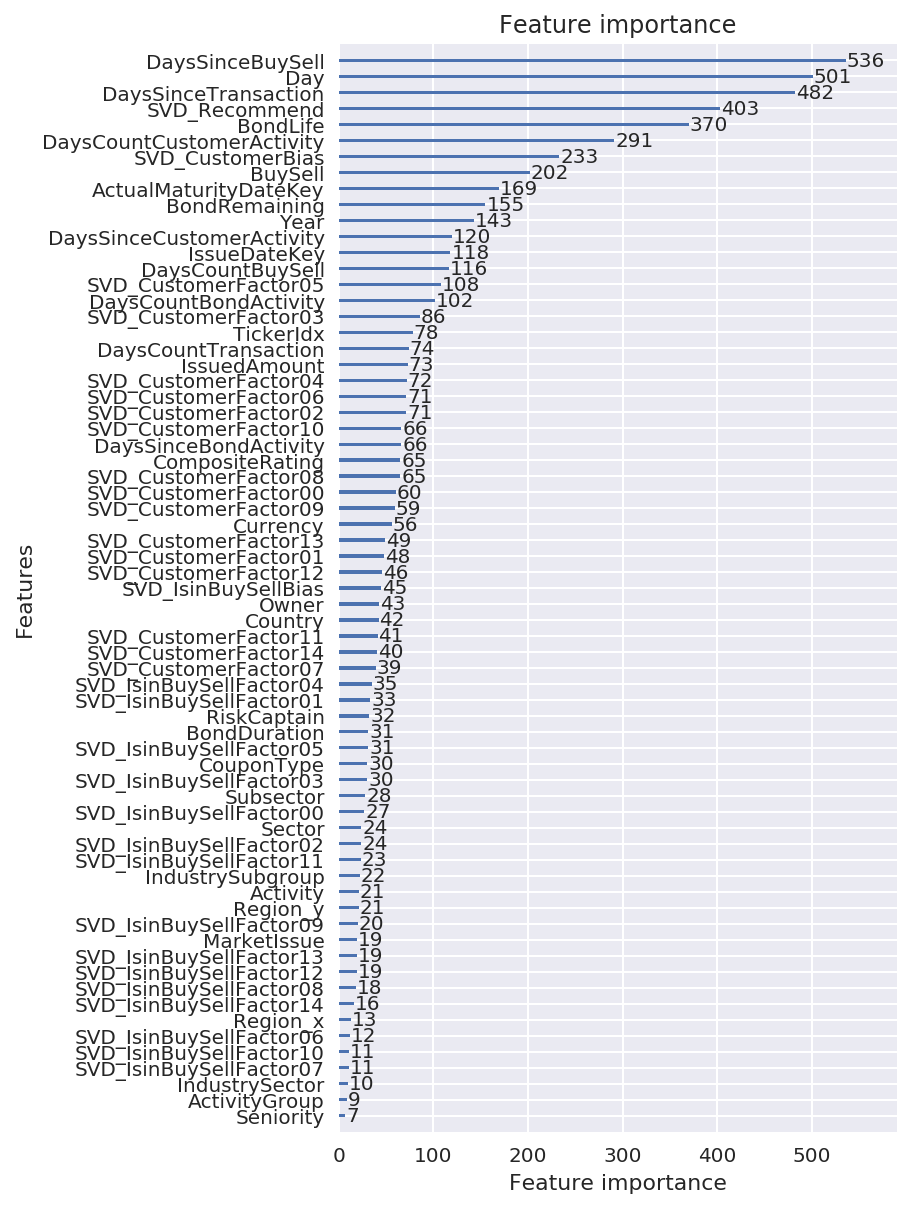

In [34]:
plot_importance(model, figsize=(5,10))